# Poisson linear inverse problem



Вид функции
$$
\textrm{minimize}_{x \in Q} \quad F(x):= D_{KL}(b, Ax) + \Psi(x)
$$
where $A\in R^{m\times n}_+$, $b\in R^m_{++}$ and $\Psi(x) = (\lambda / 2) \cdot \| x \|_2^2$, $Q$ - шар на положительном ортанте.

Константа относительной гладкости относительно прокса Берга равна $L \geq \| b \|_1$ и TSE $\gamma > 0.5$ (см. статью Hanzley).

Так как FW работает только на ограниченных множествах, то мы тут ограничиваем множество $R^n_{++}$ дополнительно шаром. 

### Данные 
Эксперименты проводились на следующих данных:
- случайно сгенерированные данные np.random

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с адаптивными параметрами $L$ и $\gamma$ (FW-adapt-full)
- Алгоритм Франк-Вульфа с адаптивным параметром $L$ и фиксированным $\gamma$ (FW-adapt-L)
- Алгоритм Франк-Вульфа с фиксированными параметрами $L$ и $\gamma$ (FW-Bregman)
- Алгоритм Франк-Вульфа с убывающим шагом $\frac{2}{k + 1}$. Алгоритм не зависит ни от каких параметров (FW-Descent Step)

### Цель эксперимента

Ответим на вопросы
1) Дает ли выигрыш в скорости сходимость адаптивность не только по $L$, но и по $\gamma$?
2) На сколько быстры алгоритмы, которые не зависят от параметров, такие как алгоритм FW с убывающим шагом (FW-Descent Step), алгоритм FW с адаптивными параметрами $L$ и $\gamma$ (FW-adapt-full)?

In [1]:
import sys
import os

# Get the parent directory of the notebook (2 levels up)
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import accbpg
from accbpg.utils import random_point_on_simplex

## Меняем размерность матрицы $m$ и $n$

В этом эксперименте нет алгоритма с убывающим шагом, потому что он сильно "дрыгается" и загораживает другие графики. Из результатов видно явное превосходство алгоритма адаптивного по двум параметрам. Можно уверенно говорить, что от адаптации есть ускорение.


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   1.887e-02   5.881e-01     0.0   2.000e+00
   500   2.086e-03   2.243e-06     0.1   1.099e+00
  1000   1.824e-03   2.243e-06     0.2   1.144e+00
  1500   1.696e-03   4.487e-06     0.3   1.093e+00
  2000   1.605e-03   1.122e-06     0.4   1.090e+00
  2500   1.565e-03   1.122e-06     0.5   1.058e+00
  3000   1.529e-03   2.243e-06     0.6   1.085e+00
  3500   1.499e-03   2.243e-06     0.7   1.055e+00
  4000   1.482e-03   2.243e-06     0.9   1.080e+00
  4500   1.468e-03   1.122e-06     1.0   1.052e+00

FW adaptive algorithm
     k      F(x)         Lk       time
     0   1.887e-02   5.881e-01     0.0
   500   2.098e-03   2.297e-03     0.1
  1000   1.881e-03   1.838e-02     0.1
  1500   1.797e-03   4.595e-03     0.2
  2000   1.730e-03   1.838e-02     0.3
  2500   1.682e-03   4.595e-03     0.4
  3000   1.642e-03   9.189e-03     0.4
  3500   1.608e-03   1.838e-02     0.5
  4000   1.579e-03   4.595e-03     0.

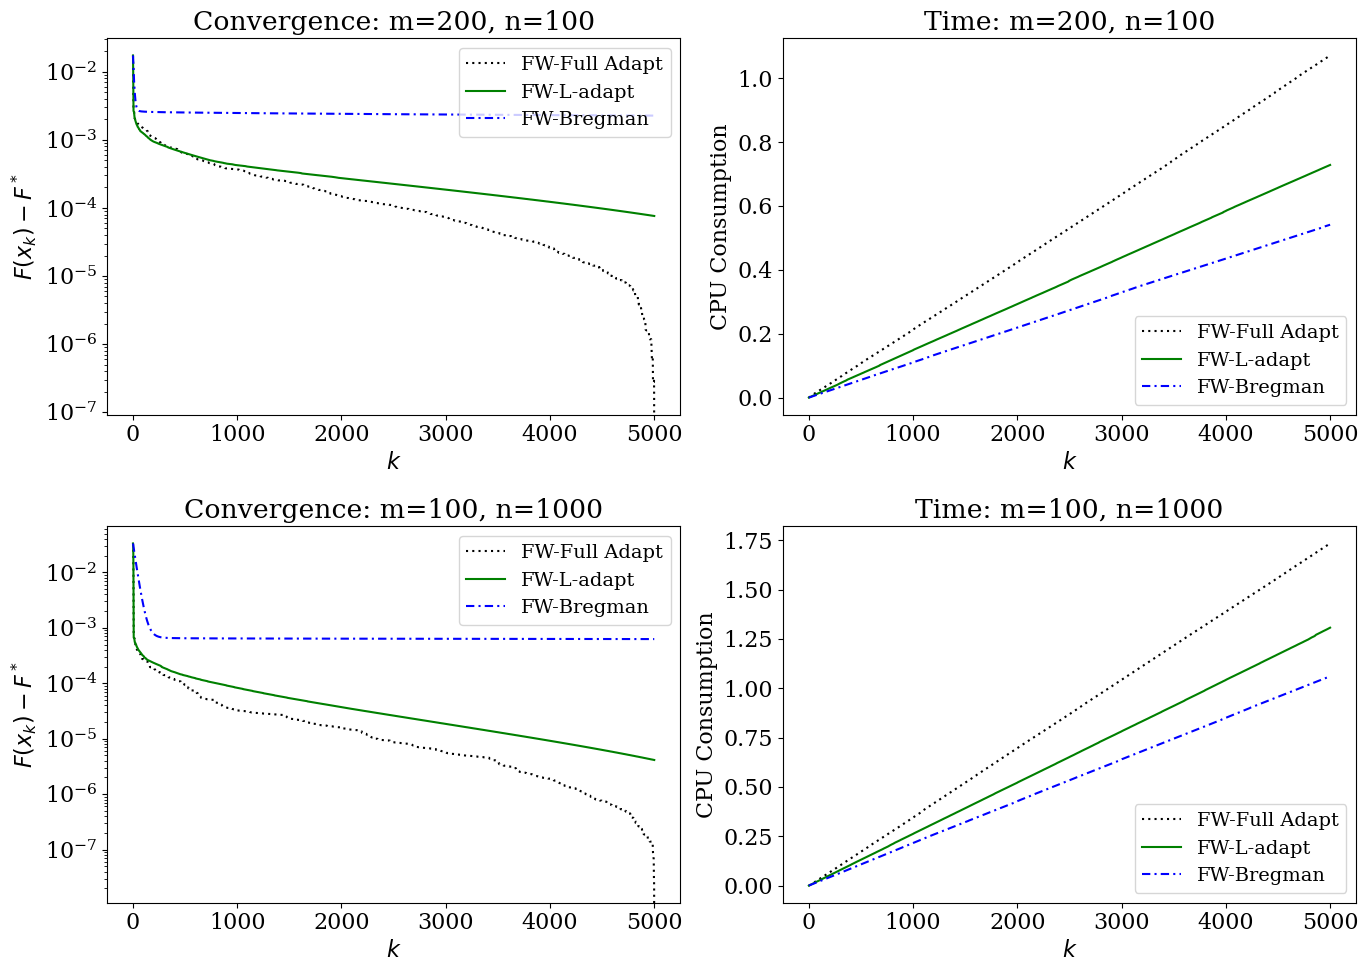

In [18]:
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14, 'font.family': 'serif'})

max_iters = 5000
ls_ratio = 2.0
divisor_for_tse = 1.5
gamma = 2.0
verbskip = 500
radius = 1

configs = [(200, 100), (100, 1000)]

labels = [r"FW-Full Adapt", r"FW-L-adapt", r"FW-Bregman"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows (cases), 2 cols (convergence + time)

for i, (m, n) in enumerate(configs):
    f, h, L, x0 = accbpg.Poisson_regrL2(m, n, normalizeA=True, lamda=0.01, noise=0.001)
    lmo = accbpg.lmo_l2_ball_positive_orthant(radius, epsilon=1e-7)

    _, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
    )
    _, F00_L_adapt, _, T_adapt = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        linesearch=True, ls_ratio=ls_ratio, verbskip=verbskip
    )
    _, F00_bregman, _, T_bregman = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        linesearch=False, verbskip=verbskip
    )

    # Left plot: Convergence
    accbpg.plot_comparisons(
        axes[i, 0],
        [F00_full_adapt, F00_L_adapt, F00_bregman],
        labels,
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$", ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )
    axes[i, 0].set_title(f"Convergence: m={m}, n={n}")

    # Right plot: Time
    accbpg.plot_comparisons(
        axes[i, 1],
        [T_full_adapt, T_adapt, T_bregman],
        labels,
        x_vals=[], plotdiff=False, yscale="linear",
        xlabel=r"$k$", ylabel=r"CPU Consumption",
        legendloc="lower right"
    )
    axes[i, 1].set_title(f"Time: m={m}, n={n}")

plt.tight_layout()

Теперь с убывающим шагом.

- На малых размерностях FW-Descent Step уверенно обходит FW-Full Adapt, который в прошлом эксперименте был лучшим.
- На больши размерностях $n=1000$ убывающий шаг сильно "дрыгается", так как у него шаг никак не настраивается и прыгает вокруг оптимума. Точность решения уже не так превосходит



FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   1.917e-02   5.864e-01     0.0   2.000e+00
   500   2.281e-03   8.948e-06     0.1   1.099e+00
  1000   1.925e-03   4.474e-06     0.2   1.043e+00
  1500   1.812e-03   4.474e-06     0.3   1.093e+00
  2000   1.730e-03   2.237e-06     0.4   1.060e+00
  2500   1.669e-03   1.119e-06     0.5   1.058e+00
  3000   1.617e-03   1.119e-06     0.7   1.085e+00
  3500   1.584e-03   1.119e-06     0.8   1.037e+00
  4000   1.545e-03   4.474e-06     0.9   1.080e+00
  4500   1.526e-03   5.593e-07     1.0   1.023e+00

FW descent step size algorithm
     k      F(x)         alpha_k       time
     1   3.735e+00   6.667e-01     0.0
   500   1.364e-03   3.984e-03     0.0
  1000   1.167e-03   1.996e-03     0.1
  1500   1.149e-03   1.332e-03     0.1
  2000   1.127e-03   9.990e-04     0.2
  2500   1.123e-03   7.994e-04     0.2
  3000   1.121e-03   6.662e-04     0.2
  3500   1.119e-03   5.711e-04     0.3
  4000   1.122e-03   4.

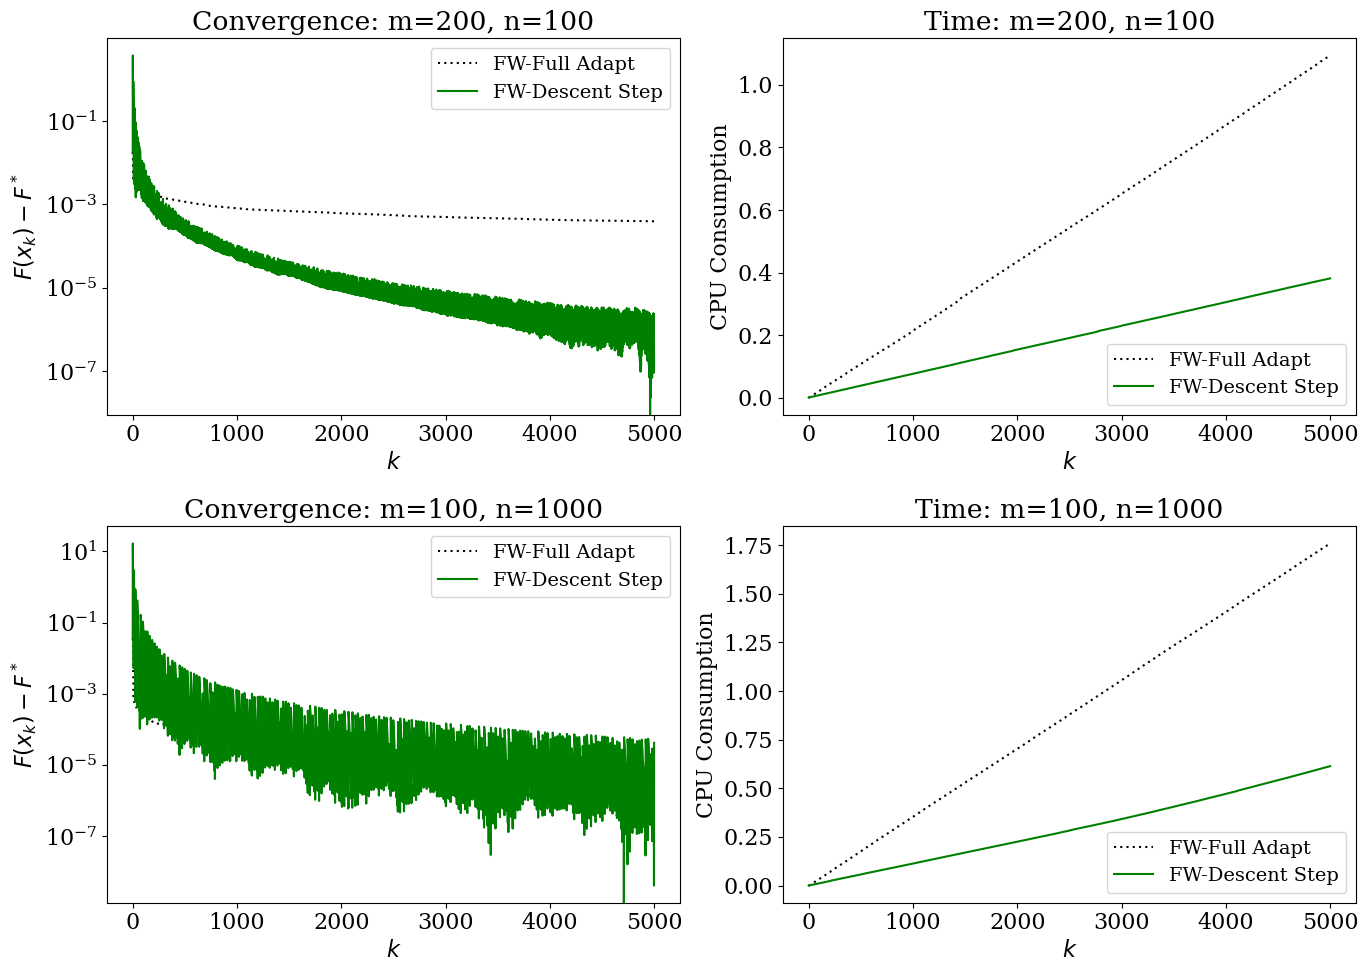

In [20]:
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14, 'font.family': 'serif'})

max_iters = 5000
ls_ratio = 2.0
divisor_for_tse = 1.5
gamma = 2.0
verbskip = 500
radius = 1

configs = [(200, 100), (100, 1000)]

labels = [r"FW-Full Adapt", r"FW-Descent Step"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows (cases), 2 cols (convergence + time)

for i, (m, n) in enumerate(configs):
    f, h, L, x0 = accbpg.Poisson_regrL2(m, n, normalizeA=True, lamda=0.01, noise=0.001)
    lmo = accbpg.lmo_l2_ball_positive_orthant(radius, epsilon=1e-7)

    _, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
    )
    _, F00_descent_step, T_descent_step, _ = accbpg.FW_alg_descent_step(
        f, h, x0, maxitrs=max_iters, lmo=lmo, verbskip=verbskip
    )

    # Left plot: Convergence
    accbpg.plot_comparisons(
        axes[i, 0],
        [F00_full_adapt, F00_descent_step],
        labels,
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$", ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )
    axes[i, 0].set_title(f"Convergence: m={m}, n={n}")

    # Right plot: Time
    accbpg.plot_comparisons(
        axes[i, 1],
        [T_full_adapt, T_descent_step],
        labels,
        x_vals=[], plotdiff=False, yscale="linear",
        xlabel=r"$k$", ylabel=r"CPU Consumption",
        legendloc="lower right"
    )
    axes[i, 1].set_title(f"Time: m={m}, n={n}")

plt.tight_layout()

## Меняем радиус допустимого множества

Чем выше радиус, тем более явно видно превосходство предложенного алгоритма FW-Full Adapt. Видимо, потому что он способен на более тонкую настройку. При том нужно иметь ввиду, что tse зафиксирована как 2.0, т.е. это самое позитивное значение для теоретической скорости сходимости.


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   1.750e-02   5.814e-01     0.0   2.000e+00
   500   2.616e-03   4.436e-06     0.1   1.099e+00
  1000   2.323e-03   2.218e-06     0.2   1.096e+00
  1500   2.086e-03   4.436e-06     0.3   1.093e+00
  2000   1.953e-03   2.218e-06     0.4   1.090e+00
  2500   1.883e-03   2.218e-06     0.5   1.058e+00
  3000   1.817e-03   1.109e-06     0.7   1.085e+00
  3500   1.782e-03   1.109e-06     0.8   1.082e+00
  4000   1.745e-03   1.109e-06     0.9   1.035e+00
  4500   1.711e-03   2.218e-06     1.0   1.052e+00

FW adaptive algorithm
     k      F(x)         Lk       time
     0   1.750e-02   5.814e-01     0.0
   500   2.591e-03   2.271e-03     0.1
  1000   2.245e-03   4.542e-03     0.2
  1500   2.127e-03   9.084e-03     0.2
  2000   2.039e-03   1.817e-02     0.3
  2500   1.969e-03   4.542e-03     0.4
  3000   1.912e-03   9.084e-03     0.4
  3500   1.865e-03   1.817e-02     0.5
  4000   1.826e-03   4.542e-03     0.

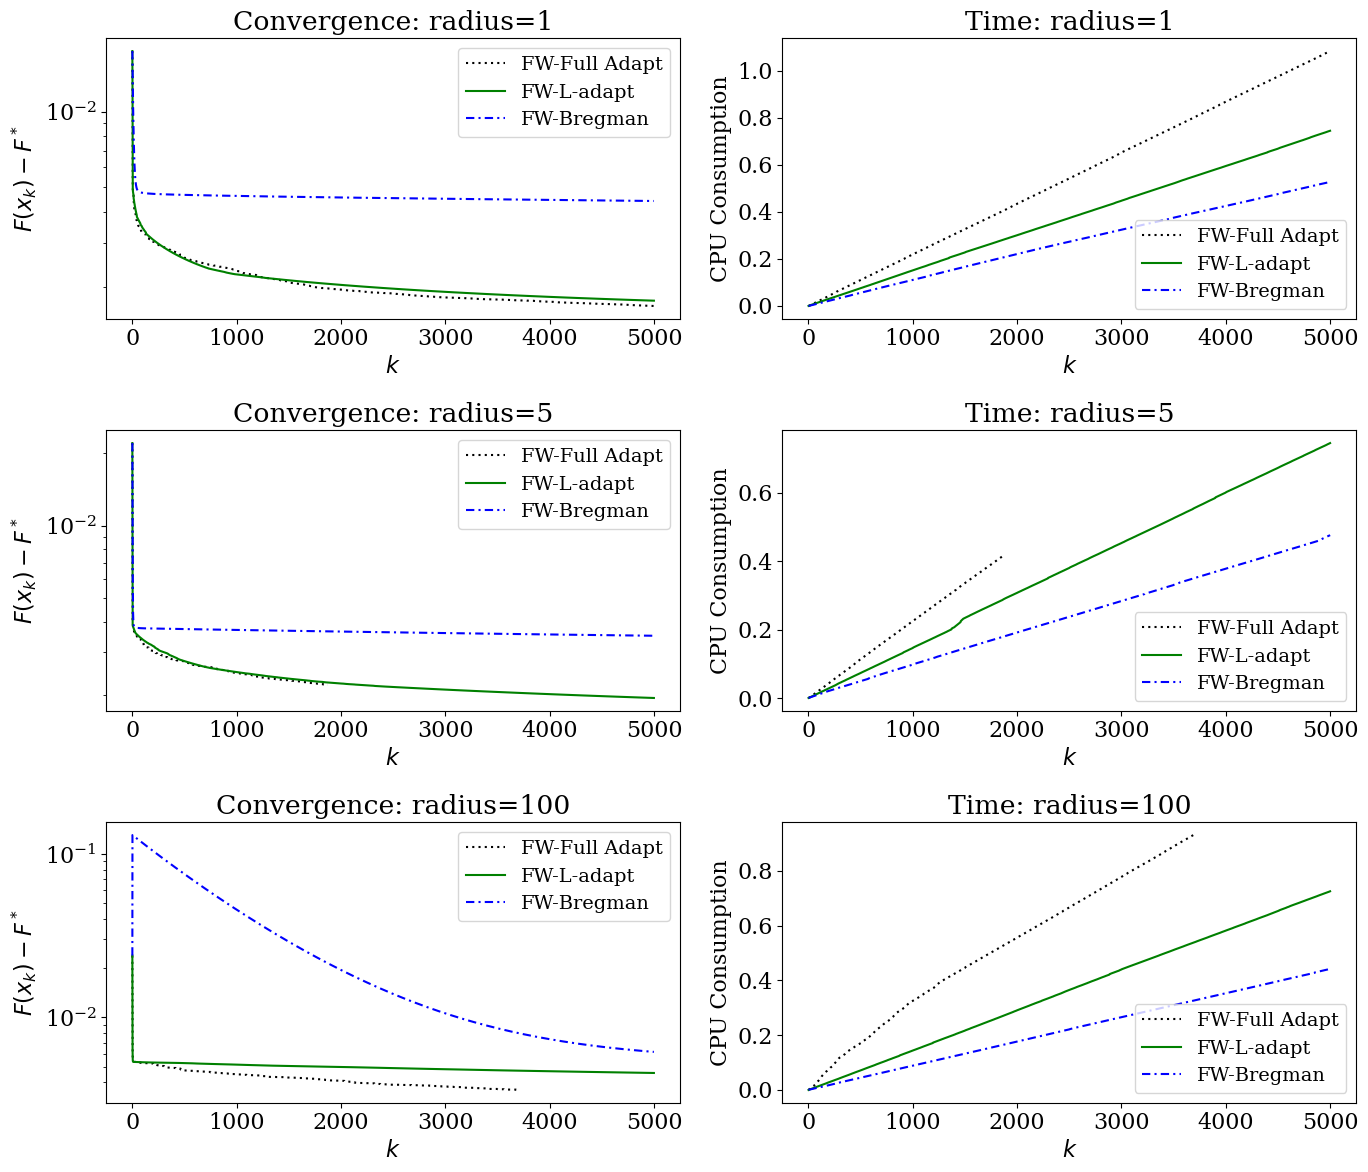

In [31]:
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14, 'font.family': 'serif'})

max_iters = 5000
ls_ratio = 2.0
divisor_for_tse = 1.5
tse = 2.0
verbskip = 500

m, n = 200, 100
radii = [1, 5, 100]
labels = [r"FW-Full Adapt", r"FW-L-adapt", r"FW-Bregman"]

fig, axes = plt.subplots(len(radii), 2, figsize=(14, 12))  # Each row = 1 radius

for i, radius in enumerate(radii):
    f, h, L, x0 = accbpg.Poisson_regrL2(m, n, normalizeA=True, lamda=0.01, noise=0.001)
    lmo = accbpg.lmo_l2_ball_positive_orthant(radius, epsilon=1e-7)

    _, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
        f, h, L, x0, maxitrs=max_iters, gamma=tse, lmo=lmo,
        ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
    )
    _, F00_L_adapt, _, T_adapt = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=tse, lmo=lmo,
        linesearch=True, ls_ratio=ls_ratio, verbskip=verbskip
    )
    _, F00_bregman, _, T_bregman = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=tse, lmo=lmo,
        linesearch=False, verbskip=verbskip
    )

    # Left: convergence plot
    accbpg.plot_comparisons(
        axes[i, 0],
        [F00_full_adapt, F00_L_adapt, F00_bregman],
        labels,
        x_vals=[], plotdiff=False, yscale="log",
        xlabel=r"$k$", ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )
    axes[i, 0].set_title(f"Convergence: radius={radius}")

    # Right: CPU time plot
    accbpg.plot_comparisons(
        axes[i, 1],
        [T_full_adapt, T_adapt, T_bregman],
        labels,
        x_vals=[], plotdiff=False, yscale="linear",
        xlabel=r"$k$", ylabel=r"CPU Consumption",
        legendloc="lower right"
    )
    axes[i, 1].set_title(f"Time: radius={radius}")

plt.tight_layout()

Добавляем к экспериментам убывающий шаг.

Снова видим, что убывающий шаг превозшел по точности, но он снова сильно "дрыгается" вокруг оптимума. Так же видно, что при увеличении радиуса FW-Full Adapt его догоняет. Т.е. FW-Full Adapt намного лучше подстраивается под конкретную ситуацию.


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   2.664e-02   6.091e-01     0.0   2.000e+00
   500   2.044e-03   4.647e-06     0.1   1.058e+00
  1000   1.721e-03   2.324e-06     0.2   1.080e+00
  1500   1.569e-03   2.324e-06     0.3   1.029e+00
  2000   1.499e-03   1.162e-06     0.5   1.077e+00
  2500   1.465e-03   5.809e-07     0.6   1.054e+00
  3000   1.434e-03   5.809e-07     0.7   1.075e+00
  3500   1.408e-03   5.809e-07     0.8   1.052e+00
  4000   1.388e-03   5.809e-07     0.9   1.101e+00
  4500   1.371e-03   5.809e-07     1.0   1.071e+00

FW descent step size algorithm
     k      F(x)         alpha_k       time
     1   3.656e+00   6.667e-01     0.0
   500   1.429e-03   3.984e-03     0.0
  1000   1.129e-03   1.996e-03     0.1
  1500   1.121e-03   1.332e-03     0.1
  2000   1.098e-03   9.990e-04     0.2
  2500   1.092e-03   7.994e-04     0.2
  3000   1.095e-03   6.662e-04     0.2
  3500   1.089e-03   5.711e-04     0.3
  4000   1.089e-03   4.

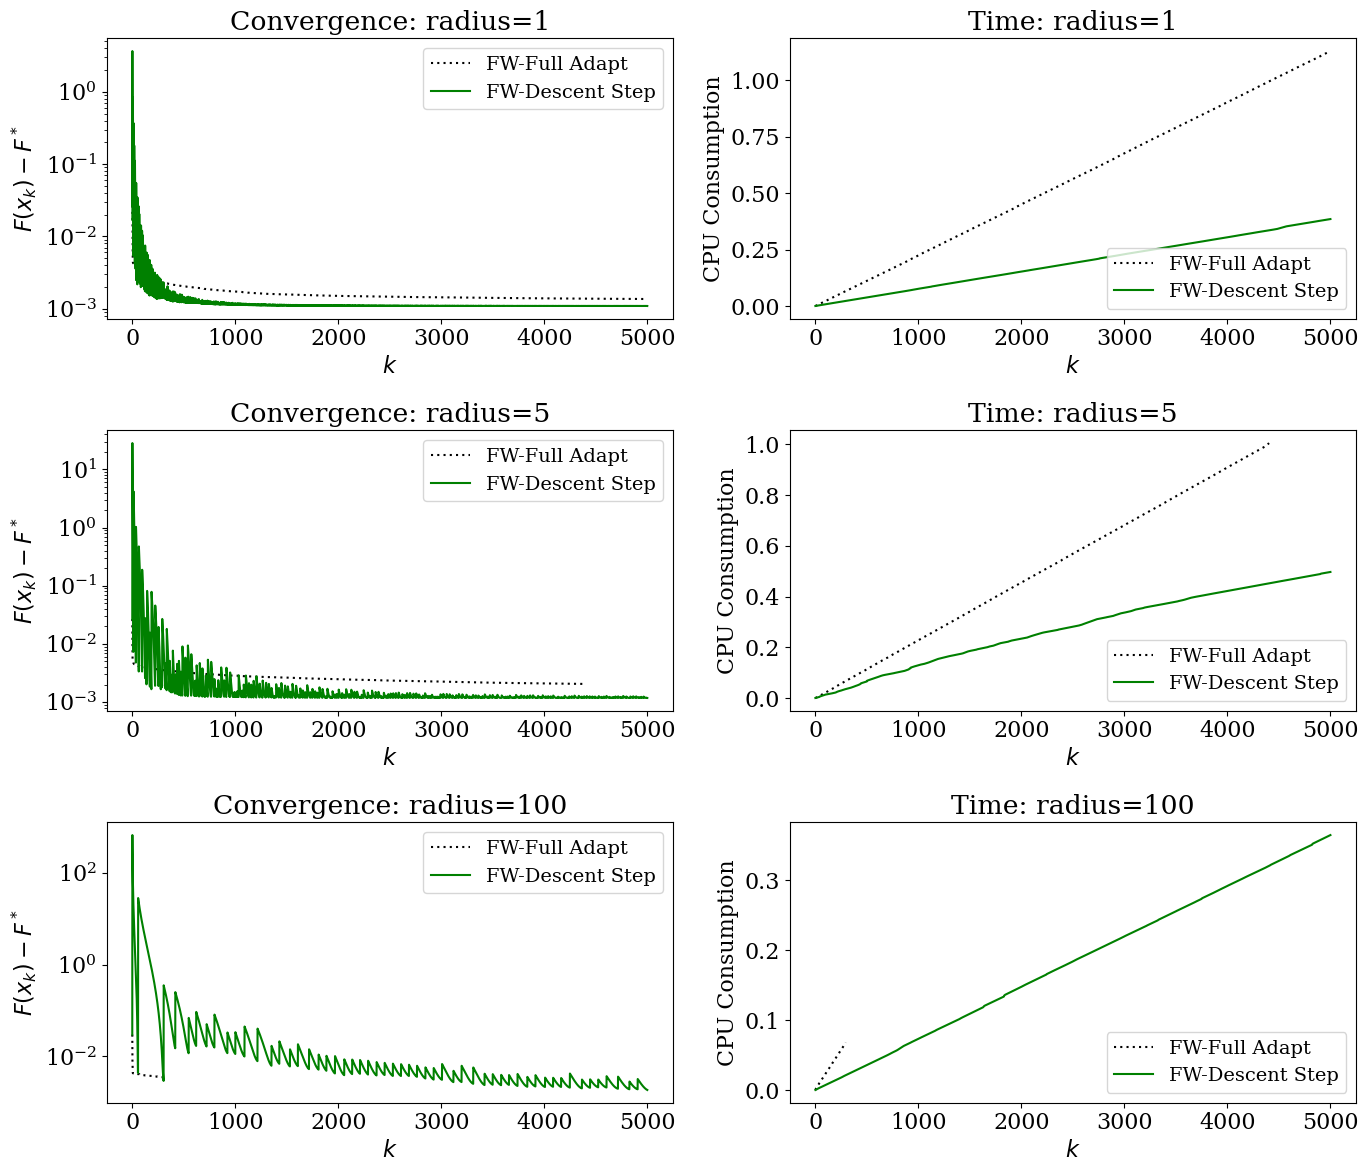

In [ ]:
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14, 'font.family': 'serif'})

max_iters = 5000
ls_ratio = 2.0
divisor_for_tse = 1.5
tse = 2.0
verbskip = 500

m, n = 200, 100
radii = [1, 5, 100]
labels = [r"FW-Full Adapt", r"FW-Descent Step"]

fig, axes = plt.subplots(len(radii), 2, figsize=(14, 12))  # Each row = 1 radius

for i, radius in enumerate(radii):
    f, h, L, x0 = accbpg.Poisson_regrL2(m, n, normalizeA=True, lamda=0.01, noise=0.001)
    lmo = accbpg.lmo_l2_ball_positive_orthant(radius, epsilon=1e-7)

    _, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
        f, h, L, x0, maxitrs=max_iters, gamma=tse, lmo=lmo,
        ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
    )
    _, F00_descent_step, T_descent_step, _ = accbpg.FW_alg_descent_step(
        f, h, x0, maxitrs=max_iters, lmo=lmo, verbskip=verbskip
    )

    # Left: convergence plot
    accbpg.plot_comparisons(
        axes[i, 0],
        [F00_full_adapt, F00_descent_step],
        labels,
        x_vals=[], plotdiff=False, yscale="log",
        xlabel=r"$k$", ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )
    axes[i, 0].set_title(f"Convergence: radius={radius}")

    # Right: CPU time plot
    accbpg.plot_comparisons(
        axes[i, 1],
        [T_full_adapt, T_descent_step],
        labels,
        x_vals=[], plotdiff=False, yscale="linear",
        xlabel=r"$k$", ylabel=r"CPU Consumption",
        legendloc="lower right"
    )
    axes[i, 1].set_title(f"Time: radius={radius}")

plt.tight_layout()

## Меняем функцию во втором слагаемом

Второе слагаемое заменим на 1-норму, т.е. негладкая функция. Вообще FW работает для гладких, но ради эксперимента можно посмотреть изменится ли что-то принципиально.

Видим без особых изменений, FW-Full Adapt снова победил.


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   6.271e+00   6.210e-01     0.0   2.000e+00
   500   1.429e-02   4.738e-06     0.1   1.089e+00
  1000   1.402e-02   2.369e-06     0.2   1.086e+00
  1500   1.390e-02   9.476e-06     0.3   1.084e+00
  2000   1.381e-02   1.185e-06     0.4   1.081e+00
  2500   1.374e-02   1.185e-06     0.5   1.079e+00
  3000   1.371e-02   1.185e-06     0.7   1.034e+00
  3500   1.368e-02   1.185e-06     0.8   1.111e+00
  4000   1.365e-02   1.185e-06     0.9   1.048e+00
  4500   1.363e-02   5.923e-07     1.0   1.070e+00

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.271e+00   6.210e-01     0.0
   500   1.421e-02   4.852e-03     0.1
  1000   1.403e-02   1.941e-02     0.1
  1500   1.395e-02   4.852e-03     0.2
  2000   1.389e-02   9.704e-03     0.3
  2500   1.383e-02   1.941e-02     0.4
  3000   1.379e-02   4.852e-03     0.4
  3500   1.375e-02   9.704e-03     0.5
  4000   1.372e-02   1.941e-02     0.

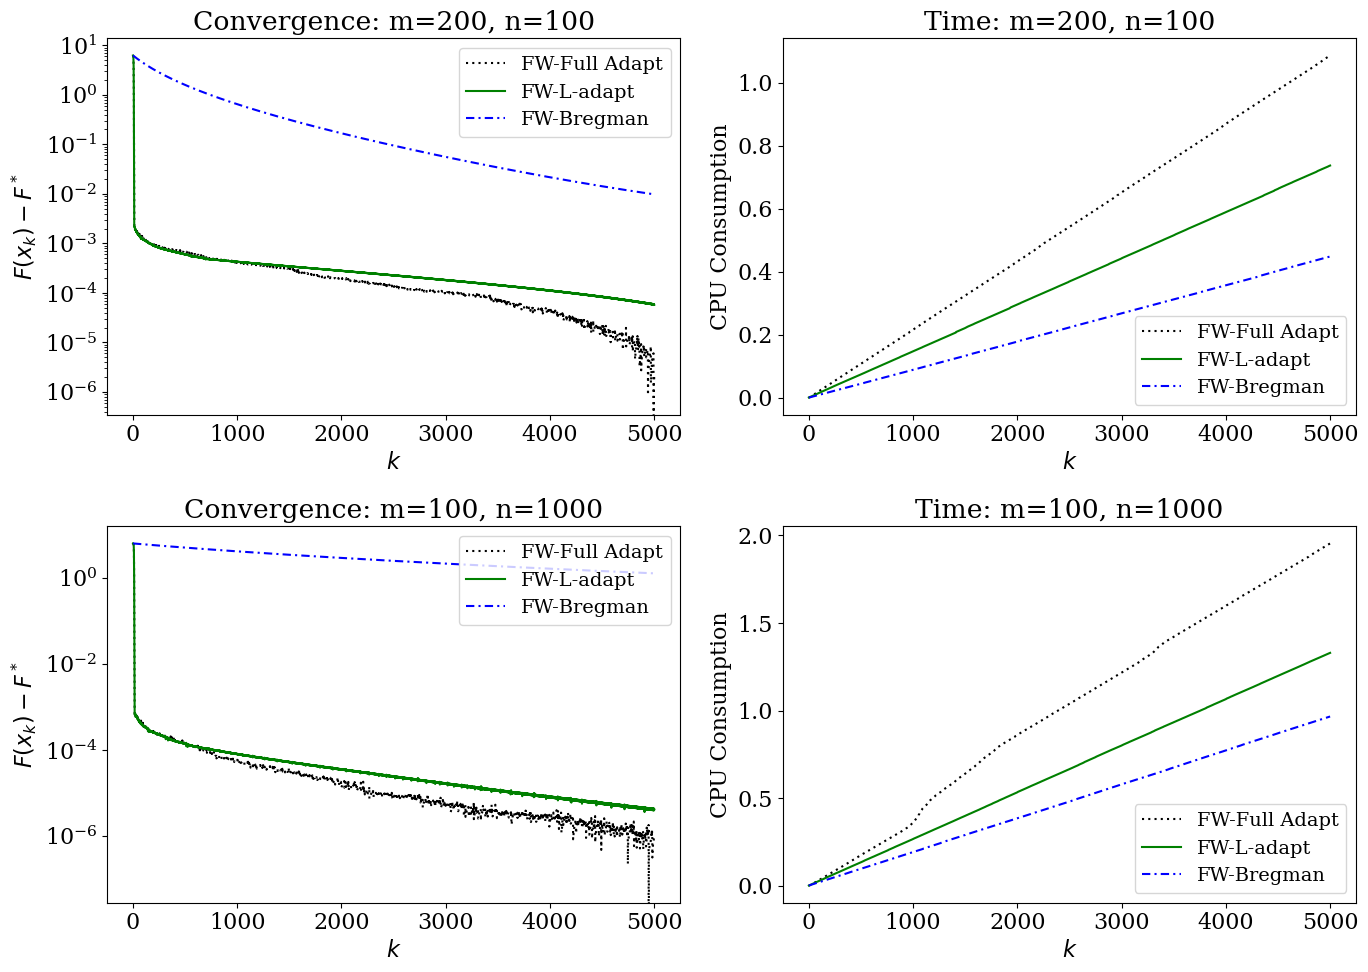

In [36]:
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14, 'font.family': 'serif'})

max_iters = 5000
ls_ratio = 2.0
divisor_for_tse = 1.5
gamma = 2.0
verbskip = 500
radius = 1

configs = [(200, 100), (100, 1000)]

labels = [r"FW-Full Adapt", r"FW-L-adapt", r"FW-Bregman"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows (cases), 2 cols (convergence + time)

for i, (m, n) in enumerate(configs):
    f, h, L, x0 = accbpg.Poisson_regrL1(m, n, normalizeA=True, lamda=0.01, noise=0.001)
    lmo = accbpg.lmo_l2_ball_positive_orthant(radius, epsilon=1e-7)

    _, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
    )
    _, F00_L_adapt, _, T_adapt = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        linesearch=True, ls_ratio=ls_ratio, verbskip=verbskip
    )
    _, F00_bregman, _, T_bregman = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        linesearch=False, verbskip=verbskip
    )

    # Left plot: Convergence
    accbpg.plot_comparisons(
        axes[i, 0],
        [F00_full_adapt, F00_L_adapt, F00_bregman],
        labels,
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$", ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )
    axes[i, 0].set_title(f"Convergence: m={m}, n={n}")

    # Right plot: Time
    accbpg.plot_comparisons(
        axes[i, 1],
        [T_full_adapt, T_adapt, T_bregman],
        labels,
        x_vals=[], plotdiff=False, yscale="linear",
        xlabel=r"$k$", ylabel=r"CPU Consumption",
        legendloc="lower right"
    )
    axes[i, 1].set_title(f"Time: m={m}, n={n}")

plt.tight_layout()

Теперь с убывающим шагом.

Тут тоже примерно так же как и на L2 регуляризации.


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   6.051e+00   6.750e-01     0.0   2.000e+00
   500   1.528e-02   2.575e-06     0.1   1.044e+00
  1000   1.495e-02   1.288e-06     0.2   1.028e+00
  1500   1.483e-02   5.150e-06     0.3   1.093e+00
  2000   1.478e-02   1.288e-06     0.4   1.060e+00
  2500   1.473e-02   1.288e-06     0.5   1.039e+00
  3000   1.467e-02   1.288e-06     0.7   1.057e+00
  3500   1.464e-02   1.288e-06     0.8   1.037e+00
  4000   1.462e-02   1.288e-06     0.9   1.080e+00
  4500   1.459e-02   1.288e-06     1.0   1.052e+00

FW descent step size algorithm
     k      F(x)         alpha_k       time
     1   8.011e-01   6.667e-01     0.0
   500   1.457e-02   3.984e-03     0.0
  1000   1.436e-02   1.996e-03     0.1
  1500   1.432e-02   1.332e-03     0.1
  2000   1.429e-02   9.990e-04     0.2
  2500   1.422e-02   7.994e-04     0.2
  3000   1.423e-02   6.662e-04     0.2
  3500   1.422e-02   5.711e-04     0.3
  4000   1.422e-02   4.

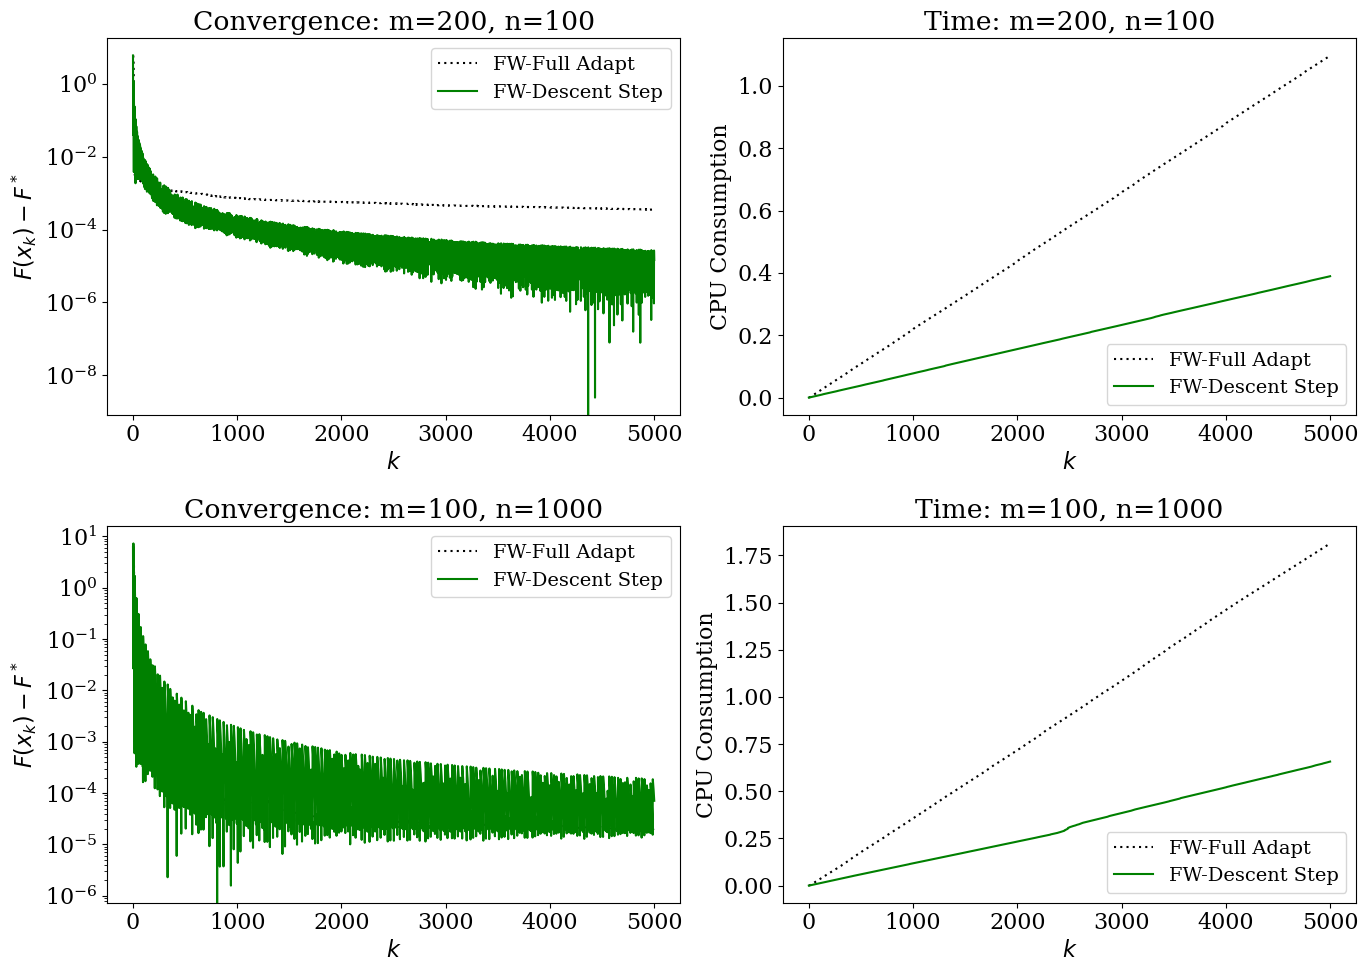

In [37]:
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14, 'font.family': 'serif'})

max_iters = 5000
ls_ratio = 2.0
divisor_for_tse = 1.5
gamma = 2.0
verbskip = 500
radius = 1

configs = [(200, 100), (100, 1000)]

labels = [r"FW-Full Adapt", r"FW-Descent Step"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows (cases), 2 cols (convergence + time)

for i, (m, n) in enumerate(configs):
    f, h, L, x0 = accbpg.Poisson_regrL1(m, n, normalizeA=True, lamda=0.01, noise=0.001)
    lmo = accbpg.lmo_l2_ball_positive_orthant(radius, epsilon=1e-7)

    _, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
    )
    _, F00_descent_step, T_descent_step, _ = accbpg.FW_alg_descent_step(
        f, h, x0, maxitrs=max_iters, lmo=lmo, verbskip=verbskip
    )

    # Left plot: Convergence
    accbpg.plot_comparisons(
        axes[i, 0],
        [F00_full_adapt, F00_descent_step],
        labels,
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$", ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )
    axes[i, 0].set_title(f"Convergence: m={m}, n={n}")

    # Right plot: Time
    accbpg.plot_comparisons(
        axes[i, 1],
        [T_full_adapt, T_descent_step],
        labels,
        x_vals=[], plotdiff=False, yscale="linear",
        xlabel=r"$k$", ylabel=r"CPU Consumption",
        legendloc="lower right"
    )
    axes[i, 1].set_title(f"Time: m={m}, n={n}")

plt.tight_layout()

# Выводы 

Эксперимент явно показал, что алгоритм адаптивный по $\gamma$ и по $L$ точно дает прирост скорости. Алгоритм адаптивный по $\gamma$ и по $L$ быстрее, чем только по $L$, и алгоритм адаптивный только по $L$ быстрее, чем вообще не адаптивный. Однако по ресурсам адаптивные алгоритмы потребляют уже больше, выполняются дОльше. Это понятно, потому что они тратят итерации на настройку параметров.

Алгоритм с убывающим шагом по скорости сходимости стабильно обходит на малых размерностях, но чем выше размерность, тем он хуже. Так же чем выше радиус, тем хуже его преимущество. В добавок он сильно "дрыгается" и поэтому точность непредсказуемо то выше, то ниже. По ресурсам ему нет равных, он всегда экономный, потому что очень простой.